# Amazon Review - Machine Learning Project

Myself [Chetan Gadge](https://www.linkedin.com/in/chetan-gadge-7b1090189/) along with [Shivam Parab](https://www.linkedin.com/in/shivam-parab-715b19199/) are creating an ML based 'Prediction model of helpfulness' under the mentorship of  [Mr. Rocky Jagtiani](https://www.linkedin.com/today/author/rocky-jagtiani-3b390649/). This project was done as the final project for the Advanced ML course.

In this course we learned various concepts related to Machine Learning but mostly focused on Natural Language Processing (NLP). Concepts involved were text classification , summarization , LDA , LSA , Name Entity Recognition etc ...

So there exist two problems in front of us :
## Problem Statements :-
> 1. Pre-rate the reviews on their 'helpfulness' factor.
> 2. To test Genuinity of 'reviewText' vs 'Score'.

### Problem Statement 1 :- Pre-rate the review on their 'helpfulness' factor.
The problem is the poor quality of Amazon reviews at the top of the forum despite the “helpfulness” rating system. The problem is that new reviews to be placed at the top of the forum, for a chance to be rated by the community. The proposed solution to this problem is to use machine learning techniques to design a system that “pre-rates” new reviews on their “helpfulness” before they are given a position at the top of the forum. This way, poor quality reviews will be more unlikely to be shown at the top of the forum, as they do not get the “freepass” because they are new. The proposed system will use a set of Amazon review data to train itself to predict a helpfulness classification (helpful, or not helpful) for new input data.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from six.moves import cPickle as pickle
import pandas as pd
import gzip
import seaborn as sns
import string
from time import time
import nltk
from nltk.corpus import stopwords 
stops = set(stopwords.words("english"))
import urllib.request as tr
#urllib.request.urlretrieve.


from IPython.display import display # Allows the use of display() for DataFrames


import warnings
warnings.filterwarnings('ignore')
FIG_SIZE = (14,8)
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
DATASET_NAME ='reviews_Musical_Instruments.json.gz'
#Random state for classifiers
RAN_STATE = 42

In [4]:
#removes extensions and adds pickle.
pickle_file_name = (DATASET_NAME[:-8]+'.pickle')
#pickle file is saved binary format.

#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists(pickle_file_name):
    print ('Pickled file already present, loading...')
    data = pd.read_pickle(pickle_file_name)
    print ('Pickle file loaded.')
else:
    data = pd.read_json("reviews_Musical_Instruments.json",
                        lines=True,
                        orient='columns')

    data.to_pickle(pickle_file_name)
print(data.shape)
data.head()


(500176, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YS9MDZP93857,0006428320,John Taylor,"[0, 0]",The portfolio is fine except for the fact that...,3,Parts missing,1394496000,"03 11, 2014"
1,A3TS466QBAWB9D,0014072149,Silver Pencil,"[0, 0]",If you are a serious violin student on a budge...,5,"Perform it with a friend, today!",1370476800,"06 6, 2013"
2,A3BUDYITWUSIS7,0041291905,joyce gabriel cornett,"[0, 0]",This is and excellent edition and perfectly tr...,5,Vivalldi's Four Seasons,1381708800,"10 14, 2013"
3,A19K10Z0D2NTZK,0041913574,TexasCowboy,"[0, 0]",Perfect for someone who is an opera fan or a w...,5,Full score: voice and orchestra,1285200000,"09 23, 2010"
4,A14X336IB4JD89,0201891859,dfjm53,"[0, 1]",How many Nocturnes does it contain? All of the...,1,Unable to determine contents,1350432000,"10 17, 2012"


#### So here we are concerned about the column named 'helpful'. So the helpful score can be evaluated as whether the review was helpful for them or not . For e.g. [5 , 7] can be evaluated as there have been 7 total rating count out of which 5 is rated as helpful review and eventually 2 can considered as not helpful.
#### So for the training ,  this label can be generated by dividing the ‘helpful’ ratings by the total ratings and check whether it exceeds a certain threshold value.
#### So let's extract only those information we need for this project:
*  The 'reviewText' will be used to generate features using natural language processing later.
*  The 'score' will be used as a feature later for the final model but for now we keep it excluded for benchmark model.
*  The 'helpful' rating will be used to generate our labels. We will train our model using these training labels. Predict the label using the test features, and measure the success of our model using the test labels . Will be explained in upcoming cells.

In [5]:
#select the columns
df = data.iloc[:, [5,4,3]]

#split numerator and denominator
df['helpful_numerator'] = df['helpful'].apply(lambda x: x[0])
df['helpful_denominator'] = df['helpful'].apply(lambda x: x[1])

# delete un-needed 'helpful catagory
del df['helpful']

#Check if we have any null values
print (df.isnull().sum())

overall                0
reviewText             0
helpful_numerator      0
helpful_denominator    0
dtype: int64


In [6]:
df.describe()

,overall,helpful_numerator,helpful_denominator
count,500176.000000,500176.000000,500176.000000
mean,4.244350,1.846428,2.378099
std,1.203374,7.736242,8.702799
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000
max,5.000000,1658.000000,1818.000000


### The amount in helpful_numerator and helpful_denominator wont matter to us much as they going to be transformed into labels later on.
## Data Preprocessing
* The count of helpful_denominator that has less than 10 ratings will first be trimmed out of the dataset.
* There are huge number of reviews, and many do not face the need of people reading them . So these reviews could be good, but by chance, do not get read and rated, they will be rated negatively by our algorithms and affect negatively in our model to classify future "good" reviews.

In [7]:
#include reviews that have more than 10 helpfulness data point only
df1 = df[(df.helpful_denominator > 10)].copy()
df1.shape

(23711, 4)

### So for the labels , we need to determine whether the 'reviewText' is helpful or not. So for that we need binary classification. For that we are going to set a threshold value (0.5) of 'helpful_numerator' divided by 'helpful_denominator'. In short , the ratio of people finding it helpful over amount of people rated. If it exceeds the threshold value , we can rate it as 'helpful = 1'  else 'helpful = 0'. 

In [8]:
#transform Helpfulness into a binary variable with 0.50 ratio
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_numerator'] \
                                 / df1.loc[:, 'helpful_denominator'] > threshold, 1, 0)
df1.head(3)

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
7,2,I bought this DVD and I'm returning it. The d...,2,12,0
11,2,I bought this DVD and I'm returning it. The d...,3,17,0
16,1,THIS IS NOT A CLAPTON CONCERT!!! IT'S AN INSTR...,12,31,0


In [9]:
#Check the balance
print ('Count:')
display(df1.groupby('Helpful').count())

Count:


,overall,reviewText,helpful_numerator,helpful_denominator
Helpful,,,,
0,4104,4104,4104,4104
1,19607,19607,19607,19607


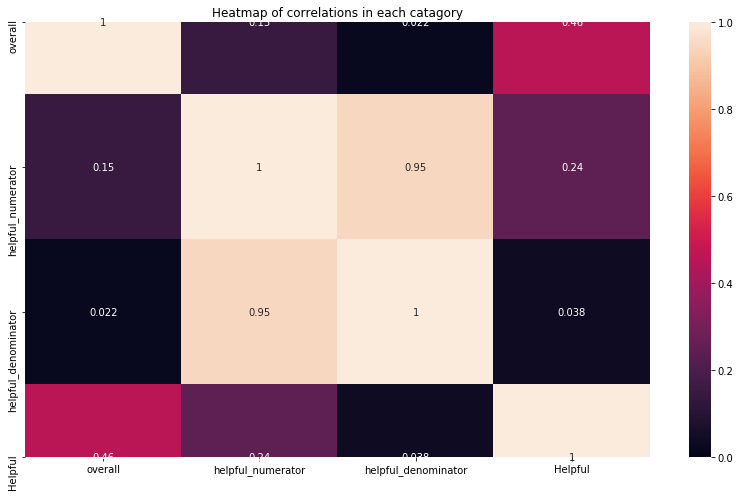

In [10]:
#Visualize correlation of the data
correlations = df1.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

In [11]:
df1

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
7,2,I bought this DVD and I'm returning it. The d...,2,12,0
11,2,I bought this DVD and I'm returning it. The d...,3,17,0
16,1,THIS IS NOT A CLAPTON CONCERT!!! IT'S AN INSTR...,12,31,0
28,5,Mat and would not hit it off. Instant persona...,14,15,1
33,5,My Background:In order to level set you as to ...,17,17,1
...,...,...,...,...,...
499663,5,"I knew Phillip was talented, but on this album...",18,22,1
499967,5,"Reuben Morgan and Ben Fielding's song ""Mighty ...",13,14,1
500005,3,I don't understand the track listing.The songs...,4,20,0
500011,5,As a longtime fan since I was eight years old ...,11,11,1


# Text Feature Generation for Benchmark model

* First we convert the text to lower case so we can run our natural language processing to produce features.
* Remove punctuations. Removing punctuation may seem like it should not be done in the case of this problem,but it will cause the learning algorithm to behave poorly.

In [12]:
# convert text to lowercase
df1.loc[:, 'reviewText'] = df1['reviewText'].str.lower()

def remove_punctuation(text):
    return text.translate(string.punctuation.translate( '"'))

df1['reviewText']=df1['reviewText'].apply(lambda x: remove_punctuation(x))
df1['reviewText'].head(4)

7     i bought this dvd and i'm returning it.  the d...
11    i bought this dvd and i'm returning it.  the d...
16    this is not a clapton concert!!! it's an instr...
28    mat and would not hit it off.  instant persona...
Name: reviewText, dtype: object

#### In order to generate more features we will use the TF-IDF vectorizer from the sci-kit learn library. We will also use the NLTK library. The pre-processing methods that we are going to employ are as follows:

> 1. Stemming : - Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root.A stemmer for English operating on the stem cat should identify such strings as cats, catlike, and catty.

> 2. Tokenizing : - Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens. It is essential to generate our TFIDF features.

> 3. Removing Stop words :- Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.

> 4. N-grams :- Makes groups of words that are 'n' long. E.g. the 2-grams for the sentence "Red color Guitar" are [Red, color] , [Red, Guitar] and [color, Guitar] . Weving more than that is computationally expensive for my computer. will stick to 2-grams and 1-grams for now. Having more than that is computationally expensive.

#### Finally we will generate TF-IDF for each of the stemmed and tokenized words and ngrams. TF-IDF is short for Term Frequency Inverse Document frequency. TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining.

>  TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

> TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

> IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

> IDF(t) = log_e(Total number of documents / Number of documents with term t in it). 

The TF-IDF weight is the product of these two numbers. We will set min_df = 0.001 for getting rid of spelling mistakes.
Words appearing infrequently are most likely typing errors and not interested for our algos thus reducing feature space and enabling our algorithm to work faster.

In [13]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

#define the vectorizer
vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
#fit the vectorizers to the data.
features = vectorizer.fit_transform(df1['reviewText'])
features

<23711x1335 sparse matrix of type '<class 'numpy.float64'>'
	with 1141776 stored elements in Compressed Sparse Row format>

We have now generated all of the features that we are going to need.

### Benchmark model

In order to establish a baseline for the project, we will look at all of the out of box models from sklearn.

The following algorithms were investigated:
> * Gaussian Naive Bayes (GaussianNB)
> * Decision Trees
> * AdaBoost
> * Random Forest
> * Logistic Regression

Lets read about these algorithms in short :-
> 1. Gaussian Navie Bayes :- In Gaussian Naive Bayes, continuous values associated with each feature are assumed to be distributed according to a Gaussian distribution. A Gaussian distribution is also called Normal distribution. When plotted, it gives a bell shaped curve which is symmetric about the mean of the feature values.

> 2. Decision Trees :- A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

> 3. AdaBoostClassifier :- AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier . Any machine learning algorithm can be used as base classifier if it accepts weights on the training set.

> 4. RandomForest :- Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean/average prediction of the individual trees. 

> 5. Logistic Regression :- Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

Now we will shuffle and split the data into 80% training and 20% testing.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

### The benefit of splitting the data into testing and training sets is that it sets valuation of how well the model is performing before using it in the real world to make predictions.

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

#### Now we will perform our algorithms using above function.
#### We will train and test on three different training sizes in order to find which one will be our benchmark.

In [16]:
# Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = RAN_STATE), 
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]
x_tr = X_train.toarray()
x_te = X_test.toarray()


# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [x_tr[0:5000],x_tr[0:10000],x_tr]
train_target_list = [y_train[0:5000], y_train[0:10000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 5000. . .
Trained model in 0.2473 seconds
Made predictions in 0.3630 seconds.
ROC_AUC score for training set: 0.8819.
Made predictions in 0.3430 seconds.
ROC_AUC score for test set: 0.6753.

Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.4770 seconds
Made predictions in 0.6400 seconds.
ROC_AUC score for training set: 0.8303.
Made predictions in 0.3680 seconds.
ROC_AUC score for test set: 0.7130.

Training a GaussianNB using a training set size of 18968. . .
Trained model in 0.9011 seconds
Made predictions in 1.3071 seconds.
ROC_AUC score for training set: 0.7873.
Made predictions in 0.3150 seconds.
ROC_AUC score for test set: 0.7342.

Training a AdaBoostClassifier using a training set size of 5000. . .
Trained model in 15.2302 seconds
Made predictions in 1.9551 seconds.
ROC_AUC score for training set: 0.8483.
Made predictions in 1.9437 seconds.
ROC_AUC score for test set: 0.7434.

Training a AdaBoostCl

#### So we can see clearly that Logistic Regression classifier did the best in our benchmark test. Not so suprising as we have mentioned above that logistic is a binary Classification and will work best on binary labels. It's interesting to compare the speed of the Logistic Regression to the other algorithms. It is quite a bit faster than all of the algorithms, and more accurate than each of them for a test size of 18,968. In order to make sure we are covering all of our bases, we should also do a visualization.

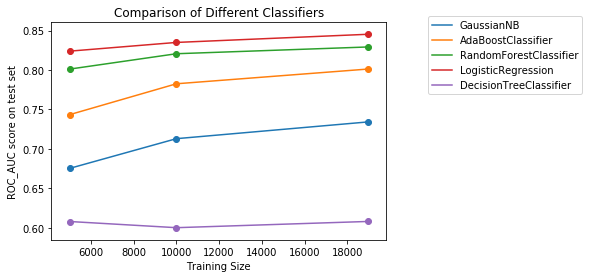

<Figure size 1008x576 with 0 Axes>

In [17]:
FIG_SIZE = (14,8)
### Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show()

As expected, the Logistic Regression is the best algorithm in terms of accuracy for all test sizes. It's final score for the area under the ROC curve was 0.8453 and a sample size of ~19,000. In addition it is the fastest. The training speed and prediction speed were 0.068s and 0.0137s respectively for a sample size of ~19,000. As our system needs to consider the trade off between accuracy and speed, the Logistic Regression algorithm represents the ideal model for our benchmark. 

In [18]:
#add Score column to features
import scipy as scipy

overall = np.array(list(df1.overall))
overall = overall.reshape(features.shape[0], 1)

features = scipy.sparse.hstack((features,scipy.sparse.csr_matrix(overall)))

features = scipy.sparse.csr_matrix(features)
features


<23711x1336 sparse matrix of type '<class 'numpy.float64'>'
	with 1165487 stored elements in Compressed Sparse Row format>

# Refinement
#### In order to improve our results we are going to try adding a new feature to our feature set. The 'overall' score category was shown before to have a correlation with 'helpful' or 0.46. Lets try adding it to the feature set and seeing how well the algorithm performs.

In [19]:
X_train2, X_test2, y_train, y_test = train_test_split(features, df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

# Grid Search

Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
# Cross-Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=5 becoming 5-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

In [20]:
from sklearn.model_selection import GridSearchCV,cross_validate,StratifiedKFold
#make the grid search object
gs2 = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,5)], 'class_weight': [None, 'balanced']},
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc'
)

#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train2, y_train)
print ("Grid search fitted.")

Fitting grid search...
Grid search fitted.


In [21]:
#print the grid search scores.
print (gs2.best_estimator_)
#gs2.grid_scores_
gs2.cv_results_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


{'mean_fit_time': array([0.07140946, 0.06340647, 0.06841183, 0.06801791, 0.06480246,
        0.08956981, 0.10441117, 0.12281013, 0.2501699 , 0.22541924,
        0.47385621, 0.48159504, 0.48578329, 0.48904266, 0.49120588,
        0.49838209, 0.4954319 , 0.5004487 , 0.50236731, 0.51824713]),
 'std_fit_time': array([0.00307743, 0.00463371, 0.00265009, 0.00570317, 0.00581296,
        0.00646955, 0.01579077, 0.01601226, 0.01986356, 0.04456255,
        0.01347284, 0.00963867, 0.02365126, 0.00877796, 0.01360232,
        0.0039245 , 0.01390586, 0.00808335, 0.01831311, 0.01417636]),
 'mean_score_time': array([0.00359616, 0.00439849, 0.00339556, 0.00359187, 0.00340328,
        0.00400038, 0.00420012, 0.00359797, 0.00359812, 0.00419807,
        0.00379329, 0.00439429, 0.00379415, 0.00439463, 0.00339527,
        0.00379329, 0.00379715, 0.00379243, 0.00440164, 0.00379453]),
 'std_score_time': array([0.00049369, 0.00048743, 0.00102119, 0.00049475, 0.00101877,
        0.00063272, 0.00116899, 0.000485

We can see the our optimized classifier is a LogisticRession with a 'C' parameter of 1 and a 'class_weight' = 'balanced'. This is the same as the default, meaning our optimization step did not actually change the parameters of the our of box model. We can now perform a prediction and measure it's results using a ROC visualization.

ROC_AUC Score: 0.8884753929986888


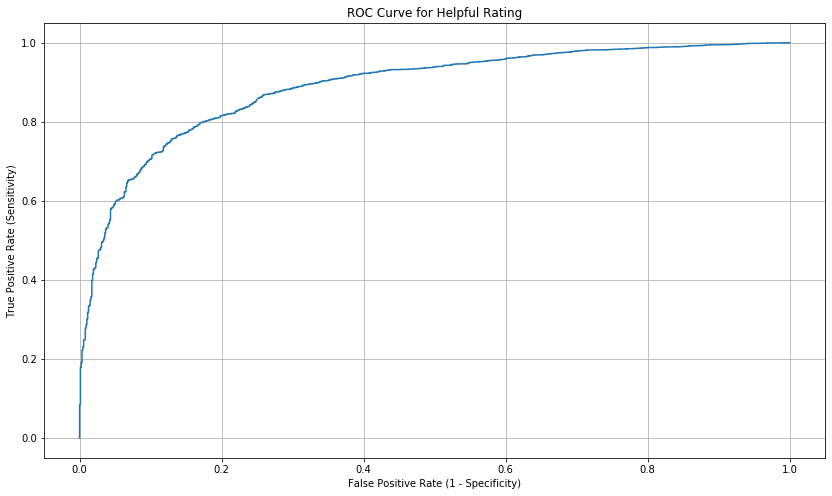

In [22]:
clf2 = gs2.best_estimator_
probas =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

In [23]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = LogisticRegression(random_state=seed)
    clf3.fit(X_train2, y_train)
    probas =clf3.predict_proba(X_test2)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.8885


The average ROC_AUC score for 100 different random_states is equal to 0.888, the same as our optimum solution. In this regard, our solution can be considered robust.

# Justification

So now our final model using 'overall' score and TFIDF features was able to score a value of 0.888 for the area under the ROC curve. Now if we compare this score to our benchmark model which scored 0.845 , this is a 4.3% improvement. As this was only the addition of one feature. The area under the AUC_ROC can be directly interpreted as accuracy.

Our goal in the beginning of this project was to design a system to automatically classify new Reviews made on amazon products as 'helpful' or 'non-helpful'. Our optimum model will correctly do this 84.5% of the time. This means that 15.5% of the time, our system will not work. 

# Free-Form Visualization

A important quality of this project is the effect of introducing a new key feature to a benchmark model. Mainly, we looked at the TFIDF features generated from amazon review text and added the 'overall_rating' that was given to the product by the reviewer. We used these features to predict how 'helpful' other users would find the review. Our results can be visualized as follows:


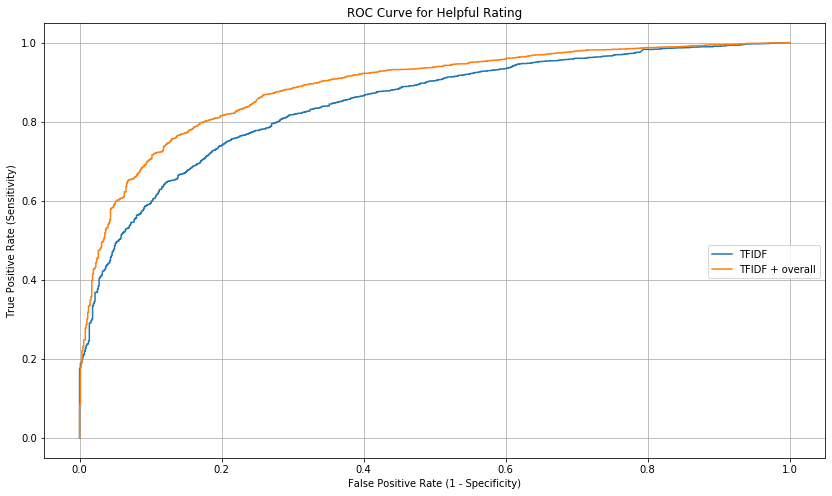

<Figure size 1008x576 with 0 Axes>

ROC_AUC Score: 0.8452977791985226


In [24]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
probas = clf.predict_proba(X_test)
clf2 = gs2.best_estimator_
probas2 =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)

plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label = 'TFIDF')
plt.plot(roc_curve(y_test, probas2[:,1])[0], roc_curve(y_test, probas2[:,1])[1], label = 'TFIDF + overall')
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.legend(bbox_to_anchor=(1.0, .5))
plt.figure(figsize=FIG_SIZE)
plt.show()

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

# Problem Statement 2 :- To test Genuinity of 'reviewText' vs 'Score'

Have you ever met in your listing that there are 1 star reviews left by non-verified purchase “buyers” with very positive comment or vice-versa with 5 star reviews with a negative comment.

For e.g. :-
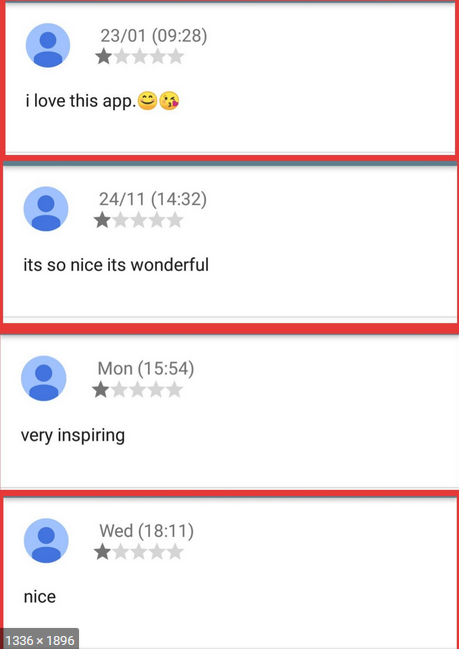


For my case, I am doubting those negative reviews are from the infringing seller who opens some buyers accounts to leave negative comment. Each account has only one review on their page, which is the one for my product.

It feels so disgusting.

## Solution : - 
>#### 1. We will be using Sentiment Analysis on 'reviewText' and give our own rating based on whether the sentiment is Positive , Negative or Neutral . 
>#### 2. Then we will compare those with score which users have given while reveiewing . If both sentiments don't match we have to filter those out.

### So what is Sentiment Analysis ?
>#### Sentiment analysis (or opinion mining) is a natural language processing technique used to determine whether data is positive, negative or neutral. Sentiment analysis is often performed on textual data to help businesses monitor brand and product sentiment in customer feedback, and understand customer needs.

In [25]:
data = pd.read_csv('Musical_instruments_reviews.csv')
data.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,3,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


### We are for now concerned with only 'reviewText' and 'overall' . So we will select only those in our dataframe.

In [26]:
#select the columns
df2 = data.iloc[:, [5,4]]

#split numerator and denominator

# delete un-needed 'helpful catagory
df2.head(10)

,overall,reviewText
0,5,"Not much to write about here, but it does exac..."
1,5,The product does exactly as it should and is q...
2,3,The primary job of this device is to block the...
3,5,Nice windscreen protects my MXL mic and preven...
4,5,This pop filter is great. It looks and perform...
5,5,So good that I bought another one. Love the h...
6,5,"I have used monster cables for years, and with..."
7,3,I now use this cable to run from the output of...
8,1,Perfect for my Epiphone Sheraton II. Monster ...
9,5,Monster makes the best cables and a lifetime w...


#### Now the next step is to divide the overall score into 3 categories . If user have given less than 3 star we categorize it as negative , for 3 star neutral and for more than 3 we mark it as Positive.

In [27]:
conditions = [
    (df2['overall'] <= 2),
    (df2['overall'] == 3),
    (df2['overall'] > 3)
    ]

# create a list of the values we want to assign for each condition
values = ['Negative', 'Neutral', 'Positive']

# create a new column and use np.select to assign values to it using our lists as arguments
df2['User_Sentiment'] = np.select(conditions, values)

# display updated DataFrame
df2.head(10)

,overall,reviewText,User_Sentiment
0,5,"Not much to write about here, but it does exac...",Positive
1,5,The product does exactly as it should and is q...,Positive
2,3,The primary job of this device is to block the...,Neutral
3,5,Nice windscreen protects my MXL mic and preven...,Positive
4,5,This pop filter is great. It looks and perform...,Positive
5,5,So good that I bought another one. Love the h...,Positive
6,5,"I have used monster cables for years, and with...",Positive
7,3,I now use this cable to run from the output of...,Neutral
8,1,Perfect for my Epiphone Sheraton II. Monster ...,Negative
9,5,Monster makes the best cables and a lifetime w...,Positive


In [28]:
df2.User_Sentiment.value_counts()

Positive    9013
Neutral      776
Negative     472
Name: User_Sentiment, dtype: int64

In [29]:
df2.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)
df2.User_Sentiment.value_counts()

Positive    9006
Neutral      776
Negative     472
Name: User_Sentiment, dtype: int64

# Preprocessing :-
> * Remove Punctuations
> * Lower Casing
> * Remove Stopwords
> * Lemmatization

In [30]:
# Import libraries
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

# Lower casing and removing punctuations
df2['reviewText'] = df2['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df2['reviewText'] = df2['reviewText'].str.replace('[^\w\s]','')

stop = stopwords.words('english')
df2['reviewText'] = df2['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Lemmatization

df2['reviewText'] = df2['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df2.reviewText.head(5)

0    much write exactly supposed filter pop sound r...
1    product exactly quite affordablei realized dou...
2    primary job device block breath would otherwis...
3    nice windscreen protects mxl mic prevents pop ...
4    pop filter great look performs like studio fil...
Name: reviewText, dtype: object

# Creating Model for Sentiment Analysis
So there are 4 types of Sentiment Analysis :-
> * Fine-Grained Sentiment
> * Emotion Detection Sentiment
> * Aspect Based
> * Intent Analysis

#### But in this Case , we are going with Aspect Based Analyzer because usually, when analyzing sentiments of texts, let’s say product reviews, you’ll want to know which particular aspects or features people are mentioning in a positive, neutral, or negative way. That's where aspect-based sentiment analysis can help, for example in this text: "The battery life of this camera is too short", an aspect-based classifier would be able to determine that the sentence expresses a negative opinion about the feature battery life.

#### Various techniques and methodologies have been developed to address automatically identifying the sentiment expressed in the text. In this project, I’ll use TextBlob, a Python sentiment analysis library, to classify whether the reviews are positive, negative, or neutral.

#### First, we’ll import the TextBlob function from textblob library. I’ll initialise the sentiment analyser from textblob, and then iterate over the 'reviewText' from the dataframe. I’ll then calculate whether the compound sentiment score is above or beneath the thresholds so that we can assign them with the positive, negative, or neutral label.

In [31]:
# Let's define our sentiment analyzer function:
polarity_score =[]
def analyze_sentiment(cleaned_verified_reviews):
    analysis = TextBlob(cleaned_verified_reviews)
    if analysis.sentiment.polarity > 0.2:
        polarity_score.append(analysis.sentiment.polarity)
        return 'Positive'
    elif analysis.sentiment.polarity >= -0.2 and analysis.sentiment.polarity <= 0.2 :
        polarity_score.append(analysis.sentiment.polarity)
        return 'Neutral'
    else:
        polarity_score.append(analysis.sentiment.polarity)
        return 'Negative'

In [32]:
df2['Review_Sentiment'] = df2['reviewText'].apply(lambda x: analyze_sentiment(x))
df2['Polarity_score'] = polarity_score
df2.head()


,overall,reviewText,User_Sentiment,Review_Sentiment,Polarity_score
0,5,much write exactly supposed filter pop sound r...,Positive,Positive,0.340000
1,5,product exactly quite affordablei realized dou...,Positive,Neutral,0.014286
2,3,primary job device block breath would otherwis...,Neutral,Neutral,0.167500
3,5,nice windscreen protects mxl mic prevents pop ...,Positive,Positive,0.333333
4,5,pop filter great look performs like studio fil...,Positive,Positive,0.800000


In [33]:
df2.Review_Sentiment.value_counts()

Positive    6143
Neutral     3994
Negative     117
Name: Review_Sentiment, dtype: int64

#### Now to be honest we are not concerned about the neutral reviews. In many cases we have seen user mentions couple of positive things about the product but is not fully satisified about the product and end up giving 3 stars as he dont want to mention negative things about it. But our model will rate it as Positive , so we dont want to contradict those reviews.

#### Hence we are concerned only about those reviews which are termed as 'Positive' but are actually 'Negative' or vice-versa . So we are removing all those reviews which includes neutral in either of the column.

In [34]:
df2 = df2[df2.User_Sentiment != 'Neutral']
df2 = df2[df2.Review_Sentiment != 'Neutral']
print(df2.shape)
df2.head(10)

(5951, 5)


,overall,reviewText,User_Sentiment,Review_Sentiment,Polarity_score
0,5,much write exactly supposed filter pop sound r...,Positive,Positive,0.340000
3,5,nice windscreen protects mxl mic prevents pop ...,Positive,Positive,0.333333
4,5,pop filter great look performs like studio fil...,Positive,Positive,0.800000
5,5,good bought another one love heavy cord gold c...,Positive,Positive,0.305556
6,5,used monster cable year good reason lifetime w...,Positive,Positive,0.333333
8,1,perfect epiphone sheraton ii monster cable wel...,Negative,Positive,0.500000
9,5,monster make best cable lifetime warranty does...,Positive,Positive,0.330000
11,4,got needed found dont really need often rarely...,Positive,Positive,0.400000
13,2,love used yamaha ypt230 work great would recom...,Negative,Positive,0.650000
16,4,fender cable perfect length sometimes find bit...,Positive,Positive,0.361905


#### So there were total 1024 neutral sentiments . Thus Removing them.

#### So in the next cell we compare two columns , one 'User_Sentiments' rated by the user themselves and second 'Review_Sentiment' generated by our model by analysing user's reviews . Labelling it 'True' if they match concluding it as a genuine review where as labelling it 'False' if they dont match concluding it as a 'Sarcastic review' or 'not genuine'.

In [35]:
comparison_column = np.where(df2["User_Sentiment"] == df2["Review_Sentiment"], True, False)
df2["result"] = comparison_column
df2.head()

,overall,reviewText,User_Sentiment,Review_Sentiment,Polarity_score,result
0,5,much write exactly supposed filter pop sound r...,Positive,Positive,0.340000,True
3,5,nice windscreen protects mxl mic prevents pop ...,Positive,Positive,0.333333,True
4,5,pop filter great look performs like studio fil...,Positive,Positive,0.800000,True
5,5,good bought another one love heavy cord gold c...,Positive,Positive,0.305556,True
6,5,used monster cable year good reason lifetime w...,Positive,Positive,0.333333,True


In [36]:
# Printing those results with 'Not Genuine' reviews ! 
df2 = df2[df2.result != True]
print(df2.shape)
df2.head()

(210, 6)


,overall,reviewText,User_Sentiment,Review_Sentiment,Polarity_score,result
8,1,perfect epiphone sheraton ii monster cable wel...,Negative,Positive,0.500000,False
13,2,love used yamaha ypt230 work great would recom...,Negative,Positive,0.650000,False
38,1,ive used lot cable always come back hosa indee...,Negative,Positive,0.500000,False
41,2,good quality cable sound good,Negative,Positive,0.600000,False
46,2,cheap good texture rubber get stiff time tell ...,Negative,Positive,0.340476,False


# Conclusion :- 

#### So we can clearly see 3rd review going as 'I love it , I used this for my Yamaha ypt-230 and it works great, I would recommend it to anyone' . User gave it a 2 star rating but clearly it is a positive review , Thus we need to filter them out as it can disturb overall ratings of that particular product and even new customers will be in a confused state.

# Reference

> Inferring networks of substitutable and complementary products. J. McAuley, R. Pandey, J. Leskovec Knowledge Discovery and Data Mining, 2015.
Image-based recommendations on styles and substitutes J. McAuley, C. Targett, J. Shi, A. van den Hengel SIGIR, 2015.

> HUI BWU Y. Anti-spam model based on semi-Naive Bayesian classification model. Journal of Computer Applications. 2009;29(3):903-904.

> Liaw A. Weiner M. Classification and Regression by randomForest. R News. 2002;Vol 2(2):18-22.

> Casanova R, Saldana S, Chew EY, Danis RP, Greven CM, et al. (2014) Application of Random Forests Methods to Diabetic Retinopathy Classification Analyses. PLoS ONE 9(6): e98587. doi: 10.1371/journal.pone.0098587

> Jones M. Viola A. Robust Real-Time Face Detection. International Journal of Computer Vision. 2004. pg 137–154. http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/

> Lowri Williams : Sentiment Analysis: Aspect-Based Opinion Mining. https://towardsdatascience.com/%EF%B8%8F-sentiment-analysis-aspect-based-opinion-mining-72a75e8c8a6d